## Install packages

In [1]:
# !pip install transformers

In [2]:
%load_ext autoreload
%autoreload 2

import os
import re

# from transformers import get_linear_schedule_with_warmup
# from transformers.optimization import AdamW
import sys
from datetime import datetime
from pathlib import Path
from sys import platform

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import src.utils as utils
import torch
from torch.utils.data import DataLoader, Dataset

%matplotlib inline

## Set up GPU

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"There are {torch.cuda.device_count()} GPU(s) available.")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce GTX 1070


## Load Dataset

In [4]:
data_path = Path("data")

all_train_df = pd.read_csv(data_path / "train.csv")
all_test_df = pd.read_csv(data_path / "test.csv")
all_val_df = pd.read_csv(data_path / "val.csv")

print(f"train: {len(all_train_df)}")
print(f"test: {len(all_test_df)}")
print(f"val: {len(all_val_df)}")

train: 67349
test: 1821
val: 872


In [5]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(all_train_df, test_size=0.1, random_state=23)
test_df = all_val_df

# Reset all indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"train: {len(train_df)}")
print(f"val: {len(val_df)}")
print(f"test: {len(test_df)}")

train: 60614
val: 6735
test: 872


In [6]:
train_df.sentence.apply(lambda d: len(d.split())).max()

52

In [7]:
val_df.sentence.apply(lambda d: len(d.split())).max()

51

In [8]:
test_df.sentence.apply(lambda d: len(d.split())).max()

47

# Fine-Tuned Bert Classifier

## PyTorch DataLoader

In [9]:
%%time
from src.datasets import SST2Dataset
from torch.utils.data import (
    DataLoader,
    RandomSampler,
    SequentialSampler,
    TensorDataset,
    random_split,
)
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16
MAX_LEN = 64
FRAC = 1

device = utils.get_device()

# Train data
print("Train")
train_data = SST2Dataset.create_dataset(
    "train", device, train_df, max_seq_len=MAX_LEN, frac=FRAC
)
train_dataloader = DataLoader(
    train_data, sampler=RandomSampler(train_data), batch_size=batch_size
)

# Val data
print("Validation")
val_data = SST2Dataset.create_dataset(
    "val", device, val_df, max_seq_len=MAX_LEN, frac=FRAC
)
val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data))

# Test data
print("Test")
test_data = SST2Dataset.create_dataset("test", device, test_df, max_seq_len=MAX_LEN)
test_dataloader = DataLoader(test_data, sampler=SequentialSampler(test_data))

Train


100%|████████████████████████████████████████████████████████████████████████████████████████████| 60614/60614 [00:04<00:00, 13897.27it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 6735/6735 [00:00<00:00, 12986.62it/s]


Test


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 872/872 [00:00<00:00, 10585.33it/s]


CPU times: user 6.17 s, sys: 461 ms, total: 6.63 s
Wall time: 6.92 s


## Train

In [10]:
from src.BertClassifier import BertClassifier
from transformers import (
    AdamW,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
)


def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler."""
    # Instantiate Bert Classifier
    device = utils.get_device()
    bert_classifier = AutoModelForSequenceClassification.from_pretrained(
        "bert-base-uncased", num_labels=2
    )
    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(
        bert_classifier.parameters(),
        lr=5e-5,  # Default learning rate
        eps=1e-8,  # Default epsilon value
    )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=total_steps  # Default value
    )
    return bert_classifier, optimizer, scheduler

In [15]:
%%time
from tqdm import tqdm
from transformers import (
    AdamW,
    AutoModelForSequenceClassification,
)

epochs = 2

utils.set_seed(42)  # Set seed for reproducibility

loss_fn = torch.nn.CrossEntropyLoss()

device = utils.get_device()
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2
)
model.to(device)

# Create the optimizer
optimizer = AdamW(
    model.parameters(),
    lr=5e-5,  # Default learning rate
    eps=1e-8,  # Default epsilon value
)

for epoch_i in range(epochs):
    model.train()
    
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for step, batch in enumerate(tepoch):
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            
            model.zero_grad()        
            logits = model(b_input_ids, b_attn_mask)
            if hasattr(logits, "logits"):
                logits = logits.logits
                    
            loss = loss_fn(logits, b_labels.long())
            
            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

CPU times: user 14min 27s, sys: 5min 48s, total: 20min 15s
Wall time: 27min 3s


In [19]:
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()
    device = utils.get_device()
    loss_fn = torch.nn.CrossEntropyLoss()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        if hasattr(logits, "logits"):
            logits = logits.logits

        # Compute loss
        loss = loss_fn(logits, b_labels.long())
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

evaluate(model, test_dataloader)

(0.3671255823718213, 89.56422018348624)

In [20]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [12]:
# Save model parameters

model_params_path = Path("model_params")

now = datetime.now().strftime("%m-%d-%Y_%H%M%S")

torch.save(
    bert_classifier.state_dict(), model_params_path / f"{now}-bert_sequence_baseline"
)

NameError: name 'bert_classifier' is not defined

## Evaluate

AUC: 0.9607
Accuracy: 89.56%


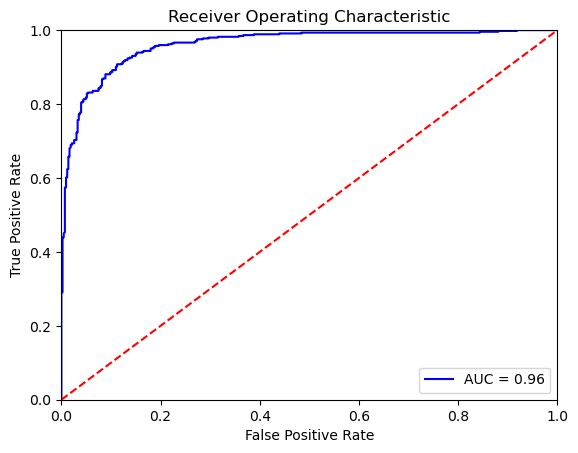

In [21]:
from src.BertClassifier import bert_predict
from src.utils import evaluate_roc

# Compute predicted probabilities on the test set
probs = bert_predict(model, test_dataloader, device)

# Evaluate the Bert classifier
# evaluate_roc(probs, y_val[: len(probs)])
evaluate_roc(probs, test_data.labels.cpu())

AUC: 0.9776
Accuracy: 93.65%


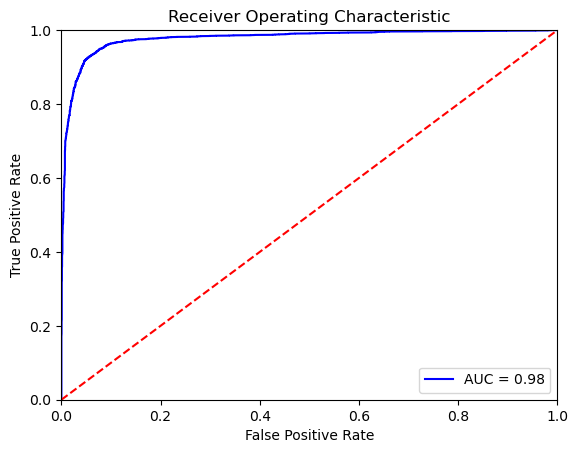

In [22]:
# Compute predicted probabilities on the validation set
probs = bert_predict(model, val_dataloader, device)

# Evaluate the Bert classifier
evaluate_roc(probs, val_data.labels.cpu())

In [ ]:
len(val_data)

In [ ]:
len(test_data)

# LOO

In [ ]:
# guids = val_data.guids
# labels = val_data.labels

In [ ]:
%%time
loo = val_data.leave_one_out(3018)

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader, device)

In [ ]:
probs